# 기본 필요 라이브러리

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
import os
from glob import glob
import io
import numpy as np
from io import BytesIO
from tensorflow import keras

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# pd.set_option('display.max.colwidth',100)
# pd.options.display.max_columns = 100

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [0]:
os.getcwd()

'/content'

### 데이터 불러오기

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv("/content/drive/My Drive/youtube_project/small_total_train_set.csv", encoding='utf-8-sig')
df.shape

(13685, 12)

In [0]:
X = df['thumbnail']
y = df['category_id']
y = np.array(y)

In [0]:
df['category_id']

0        0
1        0
2        0
3        0
4        0
        ..
13680    6
13681    6
13682    6
13683    6
13684    6
Name: category_id, Length: 13685, dtype: int64

In [0]:
df.iloc[2200,]

Unnamed: 0                                                         678
Unnamed: 0.1                                                       678
channel_name                                              부동산 읽어주는 남자 
subscribers                                                     391000
video_name                          부자가 되기위해 지켜야 할 3가지 원칙 1부ㅣ부동산읽어주는남자
days_after_upload                                                  730
video_duration                                                    1114
hits                                                            538421
likes_num                                                         4800
dislikes_num                                                       455
category_id                                                          1
thumbnail            https://i.ytimg.com/vi/xlXp7P3vJy4/hqdefault.j...
Name: 2200, dtype: object

In [0]:
len(X)

13685

# Train image features extraction

- url -> 이미지로 변환

In [0]:
from keras.preprocessing import image

In [0]:
X_img = []
for i in X :
    url = i
    response = requests.get(url) 
    img = Image.open(io.BytesIO(response.content)) 
    size = (168,94)

    img = img.resize(size)
    # img = img.convert("RGB")
    img = image.img_to_array(img)
    
    X_img.append(img)
X_img = np.array(X_img)

In [0]:
X_img.shape, y.shape

((13685, 94, 168, 3), (13685,))

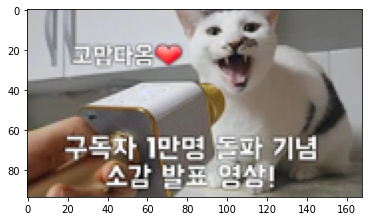

In [0]:
plt.imshow(X_img[0]/255)
# X_img.shape

# hpercent = (baseheight / float(img.size[1]))
# wsize = int((float(img.size[0]) * float(hpercent)))
# img = img.resize((wsize, baseheight), PIL.Image.ANTIALIAS)

## Transfer learning

In [0]:
# 그냥 validation_spilt 옵션 주자
# X_train = X_img
# y_train = y
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_img, y)
X_train.shape, X_valid.shape
y_train.shape

(10263,)

In [0]:
pre_trained_vgg = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(94, 168, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 94, 168, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 94, 168, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 94, 168, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 47, 84, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 47, 84, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 47, 84, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 23, 42, 128)       0     

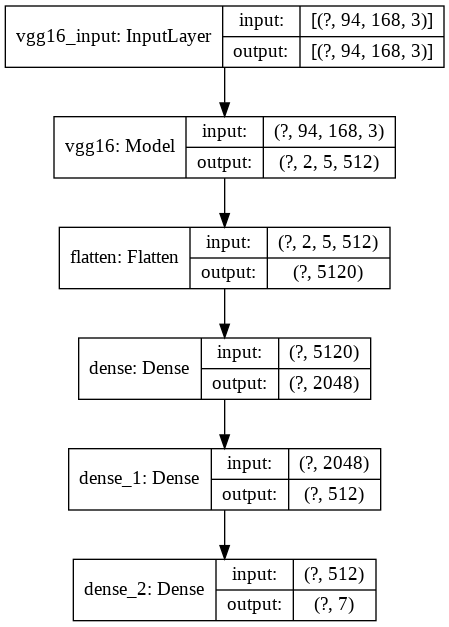

In [0]:
keras.utils.plot_model(additional_model, show_shapes=True)

### 단순예측

In [0]:
additional_model = keras.models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(keras.layers.Flatten()) # 5120
additional_model.add(keras.layers.Dense(2048, activation='relu'))
additional_model.add(keras.layers.Dense(512, activation='relu'))
additional_model.add(keras.layers.Dense(7, activation='softmax'))
 
additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              10487808  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 3591      
Total params: 26,255,175
Trainable params: 11,540,487
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# additional_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
# history = additional_model.fit(X_train, y_train, epochs=10, validation_split=0.3)

# # score = additional_model.evaluate(X_test, y_test)

# # X_new = X_test[:10] # pretend we have new images
# # y_pred = additional_model.predict(X_new)

Epoch 1/10
225/225 [==============================] - 11s 50ms/step - loss: 2.4337 - accuracy: 0.7021 - val_loss: 0.8930 - val_accuracy: 0.7295
Epoch 2/10
225/225 [==============================] - 10s 46ms/step - loss: 0.3516 - accuracy: 0.8950 - val_loss: 1.5264 - val_accuracy: 0.6976
Epoch 3/10
225/225 [==============================] - 10s 46ms/step - loss: 0.1756 - accuracy: 0.9449 - val_loss: 0.9058 - val_accuracy: 0.7993
Epoch 4/10
225/225 [==============================] - 10s 46ms/step - loss: 0.1055 - accuracy: 0.9715 - val_loss: 1.0977 - val_accuracy: 0.7957
Epoch 5/10
225/225 [==============================] - 10s 46ms/step - loss: 0.1252 - accuracy: 0.9656 - val_loss: 1.1768 - val_accuracy: 0.7834
Epoch 6/10
225/225 [==============================] - 10s 46ms/step - loss: 0.0922 - accuracy: 0.9740 - val_loss: 1.3787 - val_accuracy: 0.7791
Epoch 7/10
225/225 [==============================] - 11s 47ms/step - loss: 0.1250 - accuracy: 0.9671 - val_loss: 1.5030 - val_accuracy:

In [0]:
additional_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = additional_model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
321/321 [==============================] - 53s 165ms/step - loss: 1.9660 - accuracy: 0.7234 - val_loss: 0.8312 - val_accuracy: 0.7575
Epoch 2/15
321/321 [==============================] - 50s 157ms/step - loss: 0.3732 - accuracy: 0.8808 - val_loss: 0.6716 - val_accuracy: 0.7981
Epoch 3/15
321/321 [==============================] - 50s 157ms/step - loss: 0.1640 - accuracy: 0.9483 - val_loss: 0.7799 - val_accuracy: 0.8030
Epoch 4/15
321/321 [==============================] - 50s 157ms/step - loss: 0.1183 - accuracy: 0.9668 - val_loss: 0.9570 - val_accuracy: 0.8194
Epoch 5/15
321/321 [==============================] - 50s 157ms/step - loss: 0.1788 - accuracy: 0.9546 - val_loss: 0.9587 - val_accuracy: 0.8139
Epoch 6/15
321/321 [==============================] - 50s 157ms/step - loss: 0.2029 - accuracy: 0.9541 - val_loss: 1.1969 - val_accuracy: 0.7969
Epoch 7/15
321/321 [==============================] - 50s 157ms/step - loss: 0.1747 - accuracy: 0.9563 - val_loss: 0.9476 - val_ac

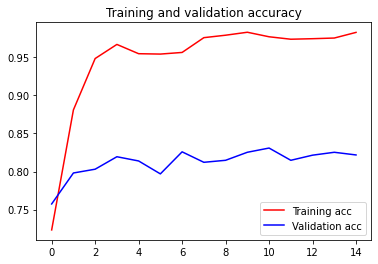

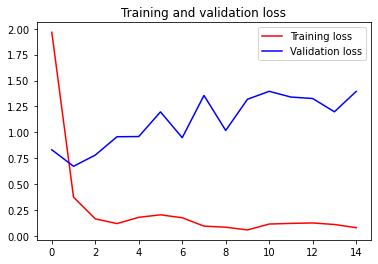

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 특성추출

In [0]:
extract_features_model = keras.models.Sequential()
extract_features_model.add(pre_trained_vgg)
extract_features_model.add(keras.layers.Flatten()) # 5120

In [0]:
extract_features_transfer_train = extract_features_model.predict(X_img)

NameError: ignored

In [0]:
extract_features_transfer_train.shape

(13685, 5120)

In [0]:
np.save("/content/drive/My Drive/youtube_project/extract_features_transfer_train", extract_features_transfer_train) # extract_features_transfer_train.npy
# /content/drive/My Drive/youtube_project/small_total_train_set.csv

# Test Image feature extraction

## Test_data

In [0]:
df2 = pd.read_csv("/content/drive/My Drive/youtube_project/small_total_test_set.csv", encoding='utf-8-sig')
df2.shape

(3500, 12)

In [0]:
Xtest = df2['thumbnail']
y_test = df2['category_id']
y_test = np.array(y_test)
len(Xtest)

3500

In [0]:
X_test = []
for i in Xtest :
    url = i
    response = requests.get(url) 
    img = Image.open(io.BytesIO(response.content)) 
    size = (168,94)

    img = img.resize(size)
    # img = img.convert("RGB")
    img = image.img_to_array(img)
    
    X_test.append(img)
    
X_test = np.array(X_test)

In [0]:
X_test.shape, y_test.shape

((3500, 94, 168, 3), (3500,))

In [0]:
extract_features_transfer_test = extract_features_model.predict(X_test)

In [0]:
np.save("/content/drive/My Drive/youtube_project/extract_features_transfer_test", extract_features_transfer_test) # extract_features_transfer_train.npy